Philippe Joly 2025

# Exposition to Symbolic regression
## A ground up implementation of a genetic programming approach to symbolic regression

This serves as a complete implementation and illustration of a simple symbolic regression (SR)algorithm based on the genetic programming (GP) like mutations, crossovers, and natural selection. The notebook relies on the [**PySR**](https://arxiv.org/abs/2305.01582) library by Miles Cranmer and the [symbolic-regression-python](https://github.com/datarobot-community/symbolic-regression-python/tree/master) repository from *datarobot-community*

### Setup

In [513]:
import operator
import numpy as np
from random import randint, random, seed
from copy import deepcopy
import matplotlib.pyplot as plt

In [514]:
# Seed used for reproducibility of the results for given functions. The functions themselves are not generated with this seed.
seed(0)

# Define global vars for the functions
TOURNAMENT_SZ, POP_SZ, CROSSOVER_RATE, MAX_GENERATIONS, REG, pop = 0,0,0,0,0,[]

### Generate Functions

Generate randomly distributed data from functions. These will be the functions we will want to infer!

In [515]:
# function definitions

## 1 dimensional functions
def f1_1(x, a, b, *args):
    return [a*x +b, f"{a}*x +{b}"]
def f1_2(x, a, b, c, *args):
    return [a*x**2 + b*x + c, f"{a}*x**2 + {b}*x + {c}"]
def f1_3(x, a, b, c, d, *args):    
    return [a*x**3 + b*x**2 + c*x + d, f"{a}*x**3 + {b}*x**2 + {c}*x + {d}"]
def f1_4(x, a, b, c, d, *args):
    return [a*np.sin(b*x+c)+d, f"{a}*sin({b}*x + {c}) + {d}"]
def f1_5(x, a, b, c, *args):
    return [a*np.exp(b*x)+c, f"{a}*exp({b}*x) + {c}"]

## 2 dimensional functions
def f2_1(x, y, a, b, c, *args):
    return [a*x + b*y + c, f"{a}*x + {b}*y + {c}"]
def f2_2(x, y, a, b, c, d, *args):
    return [a*x**2 + b*y**2 + c*x*y + d, f"{a}*x**2 + {b}*y**2 + {c}*x*y + {d}"]
def f2_3(x, y, a, b, c, d, e, *args):
    f = [f1_5(x, a, b, c), f1_5(y, d, e, 0)]
    return [f[0][0] + f[1][0], f[0][1] + "+"+ f[1][1]]
def f2_4(x, y, a, b, c, d, e, *args):
    return [a*np.sin(b*x)*np.exp(c*y)+d*x**2+e*x*y, f"{a}*sin({b}*x)*exp({c}*y) + {d}*x**2 + {e}*x*y"]

## 3 dimensional functions  
def f3_1(x, y, z, a, b, c, d, *args):
    return [a*x + b*y + c*z + d, f"{a}*x + {b}*y + {c}*z + {d}"]
def f3_2(x, y, z, a, b, *args):
    return [a*x**2 + b*y**2 + np.exp(z*y), f"{a}*x**2 + {b}*y**2 + exp(z*y)"]

linear_fxns = [
    [f1_1],
    [f2_1],
    [f3_1]
]
poly_fxns = [
    [f1_1, f1_2, f1_3],
    [f2_1, f2_2],
    [f3_1]
]
all_fxns = [
    [f1_1, f1_2, f1_3, f1_4, f1_5], 
    [f2_1, f2_2, f2_3, f2_4], 
    [f3_1, f3_2]
    ]


In [516]:
def generate_data(fxns, num_pts, num_per_f, sigma):
    X1 = np.linspace(-10, 10, num_pts[0]).reshape(-1,1)
    x = X1[:,0] 
    
    l2 = np.linspace(-10, 10, np.int16(np.sqrt(num_pts[1])))
    x2, y2 = np.meshgrid(l2,l2)
    X2 = np.column_stack([x2.ravel(), y2.ravel()])
    x2, y2 = X2[:,0], X2[:,1]

    l3 = np.linspace(-10, 10, np.int16(np.cbrt(num_pts[2])))
    x3, y3, z3 = np.meshgrid(l3,l3,l3) 
    X3 = np.column_stack([x3.ravel(), y3.ravel(), z3.ravel()])
    x3, y3, z3 = X3[:,0], X3[:,1], X3[:,2]

    data = []

    for num_input in range(len(fxns)):
        data.append([])
        for f in fxns[num_input]:
            for _ in range(num_per_f):
                # generate random coefficients
                a, b, c, d, e = np.random.randint(-4, 5, 5)

                # generate data from functions
                if num_input == 0:
                    ## only for homogeneous coeffs
                    b = 0 
                    data[-1].append(f(x, a, b, c, d, e))
                elif num_input == 1:
                    c =  0
                    data[-1].append(f(x2, y2, a, b, c, d, e))
                elif num_input == 2:
                    d = 0 
                    data[-1].append(f(x3, y3, z3, a, b, c, d, e))

                # Add gaussion noise
                noise = np.random.normal(loc=0, scale=sigma, size=data[-1][-1][0].shape)
                data[-1][-1][0] += noise

    return ([X1, X2, X3], data)

def print_fxns(data):
    in_vars = ["x", "x, y", "x, y, z"]
    for i, d in enumerate(data):
        print(f"Dimension {i+1}:")
        for j, f in enumerate(d):
            print(f"Function {j+1}: f({in_vars[i]}) = {f[1]}")
        print()

In [517]:
X, data = generate_data(linear_fxns, num_pts=[100, 100**2, 21**3], num_per_f=1, sigma=0.1)

print_fxns(data)

Dimension 1:
Function 1: f(x) = -4*x +0

Dimension 2:
Function 1: f(x, y) = -1*x + 2*y + 0

Dimension 3:
Function 1: f(x, y, z) = -4*x + -3*y + 0*z + 0



### Symbolic Regression Setup

This will be the setup of the data stuctures and genetic programming algorithms used in symbolic regression.

The expressions will be expressed as [**Binary Expression Trees**](https://en.wikipedia.org/wiki/Binary_expression_tree)

In [518]:
vals_1 = [
    {"var_name": "x", "var_idx": 0}
    ]
vals_2 = [
    {"var_name": "x","var_idx": 0}, 
    {"var_name": "y","var_idx": 1}
    ]
vals_3 = [
    {"var_name": "x","var_idx": 0}, 
    {"var_name": "y","var_idx": 1}, 
    {"var_name": "z","var_idx": 2}
    ]
vals = [vals_1, vals_2, vals_2]

def safe_div(x, y):
    return x/y if y else 0

operarions = [
    {"op": operator.add, "arg_num": 2, "op_fmt": "({} + {})"},
    {"op": operator.sub, "arg_num": 2, "op_fmt": "({} - {})"},
    {"op": operator.mul, "arg_num": 2, "op_fmt": "({} * {})"},
    {"op": safe_div, "arg_num": 2, "op_fmt": "({} / {})"},
    {"op": operator.neg, "arg_num": 1, "op_fmt": "-({})"}
]
# operator.pow, sin, exp, log, sqrt, etc. to add

In [519]:
# The following will print and evaluate the operations from the binary expression tree starting from a root node (using recursion)

def render_ops(node):
    if "children" not in node:
        return node["var_name"]
    else:
        return node["op_fmt"].format(*[render_ops(c) for c in node["children"]])

def eval_ops(node, row):
    if "children" not in node:
        return row[node["var_idx"]]
    else:
        return node["op"](*[eval_ops(c, row) for c in node["children"]])

In [520]:
# Utility function to get number of leaf nodes in the expression tree

def leaf_count(node):
    if "children" not in node:
        return 1
    else:
        return sum([leaf_count(c) for c in node["children"]])

In [521]:
# The following will generate a random expression tree with a given maximum depth. 
# Notice that, as the depth increases, the probability of a leaf node increases as well.

def gen_random_func(depth, vals):
    if randint(0, 5*2) >= depth *2:
        op = operarions[randint(0, len(operarions)-1)]
        return {
            "op": op["op"],
            "op_fmt": op["op_fmt"],
            "children": [gen_random_func(depth+1, vals) for _ in range(op["arg_num"])]
        }
    else:
        idx = randint(0, len(vals)-1)
        return vals[idx]

In [522]:
# This recursive function will randomly select a node from the tree for processes like mutations or crossovers.
# Notice probability of selecting a node increasing with the depth of the node.

def get_random_node(node, parent, depth):
    if "children" not in node:
        return parent
    elif randint(0, 5*2) < depth *2:
        return node
    else:
        children_num = len(node["children"])
        return get_random_node(
            node["children"][randint(0, children_num-1)], 
            node, depth+1
            )

In [523]:
# The following function will perform a mutation on a given node.
# It randomly replaces one of the children of the node with a new random function.

def mutate(node, vals):
    child = deepcopy(node)
    mutation_node = get_random_node(child, None, 0)
    children_num = len(mutation_node["children"])

    mutation_node["children"][randint(0, children_num-1)] = gen_random_func(0, vals)

    return child

In [524]:
# The following function will perform a crossover between two nodes.
# It randomly replaces one of the first parent's subtrees with the selected subtree from the second parent.

def crossover(node_1, node_2):
    child = deepcopy(node_1)
    cross_1 = get_random_node(child, None, 0)
    cross_2 = get_random_node(node_2, None, 0)

    children_num = len(cross_1["children"])
    cross_1["children"][randint(0, children_num-1)] = cross_2

    return child

In [525]:
# The following function will evaluate the fitness of a given function.
# We choose to use the mean squared error loss function as the fitness function, penalized by the complexity of the function.

def get_fitness(func, func_preds, f_data):
    mse = np.mean((func_preds - f_data)**2)
    complexity_penalty = leaf_count(func) ** REG

    return mse * complexity_penalty

In [526]:
# The following function will generate a random subset of the population, and, from that, it will return the function with the lowest fitess.

def get_random_func(pop, fitness):
    tournament_funcs = [
        randint(0, POP_SZ-1) for _ in range(TOURNAMENT_SZ)
        ]
    funcs_fitness = [
        (fitness[i], pop[i]) for i in tournament_funcs
        ]
    
    return min(funcs_fitness, key=lambda x: x[0])[1]

In [527]:
# The following function will generate a child function from the population.
# It will randomly select a parent function (decided in tournament fashion), and, with a given probability, it will perform a mutation or a crossover with another parent function.

def get_child(pop, fitness, vals):
    parent_1 = get_random_func(pop, fitness)

    if random() > CROSSOVER_RATE:
        parent_2 = get_random_func(pop, fitness)
        return crossover(parent_1, parent_2)
    else:
        return mutate(parent_1, vals)

### Symbolic Regression Implementation

This is the main loop for symbolic regression.

In [544]:
# Plot infered function and actual function

def compare_3d_plot(X, preds, data):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})
    
    ax1.set_title("Actual Function")
    ax1.plot_trisurf(X[:,0], X[:,1], data, cmap="viridis", alpha=0.7)
    ax2.set_title("Symbolic Regression Prediction")
    ax2.plot_trisurf(X[:,0], X[:,1], preds, cmap="plasma", alpha=0.7)

    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_label("Z")
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")
    ax2.set_label("Z")

    plt.tight_layout()
    plt.show()

In [528]:
TOURNAMENT_SZ =3
POP_SZ = 300
CROSSOVER_RATE = 0.7
MAX_GENERATIONS = 10
REG = 0.5

In [529]:
num_input = 1
pop = [gen_random_func(0, vals[num_input]) for _ in range(POP_SZ)] 

X_f = X[num_input]
data_f = data[num_input][0][0]
f =  data[num_input][0][1]

In [530]:
global_best = float("inf")

for gen in range(MAX_GENERATIONS):
    fitness = []
    for func in pop:
        preds = np.array([eval_ops(func, row) for row in X_f])

        fit_score = get_fitness(func, preds, data_f)
        fitness.append(fit_score)

        if fit_score < global_best:
            global_best = fit_score
            best_pred = preds
            best_func = func

    print("Generation %d\nBest Score: %.2f\nMedian Score: %.2f\nBest function %s\n" 
        % (
              gen, 
              global_best, 
              np.median(fitness),
              render_ops(best_func)
        )
    )

    pop = [get_child(pop, fitness, vals[num_input]) for _ in range(POP_SZ)]

print("Best Global Score: %.2f\nBest function %s\nActual function %s" 
    % (
        global_best, 
        render_ops(best_func),
        f
    )
)

Generation 0
Best Score: 48.11
Median Score: 2120.71
Best function (y + y)

Generation 1
Best Score: 48.11
Median Score: 1505.92
Best function (y + y)

Generation 2
Best Score: 0.02
Median Score: 1145.81
Best function (y - (x - -(-(y))))

Generation 3
Best Score: 0.02
Median Score: 833.19
Best function (y - (x - -(-(y))))

Generation 4
Best Score: 0.02
Median Score: 971.54
Best function (y - (x - -(-(y))))

Generation 5
Best Score: 0.02
Median Score: 944.01
Best function (y - (x - -(-(y))))

Generation 6
Best Score: 0.02
Median Score: 790.81
Best function (y - (x - -(-(y))))

Generation 7
Best Score: 0.02
Median Score: 859.63
Best function -(-(-((x + (-(y) - y)))))

Generation 8
Best Score: 0.02
Median Score: 759.73
Best function -(-(-((x + (-(y) - y)))))

Generation 9
Best Score: 0.02
Median Score: 924.36
Best function -(-(-((x + (-(y) - y)))))

Best Global Score: 0.02
Best function -(-(-((x + (-(y) - y)))))
Actual function -1*x + 2*y + 0


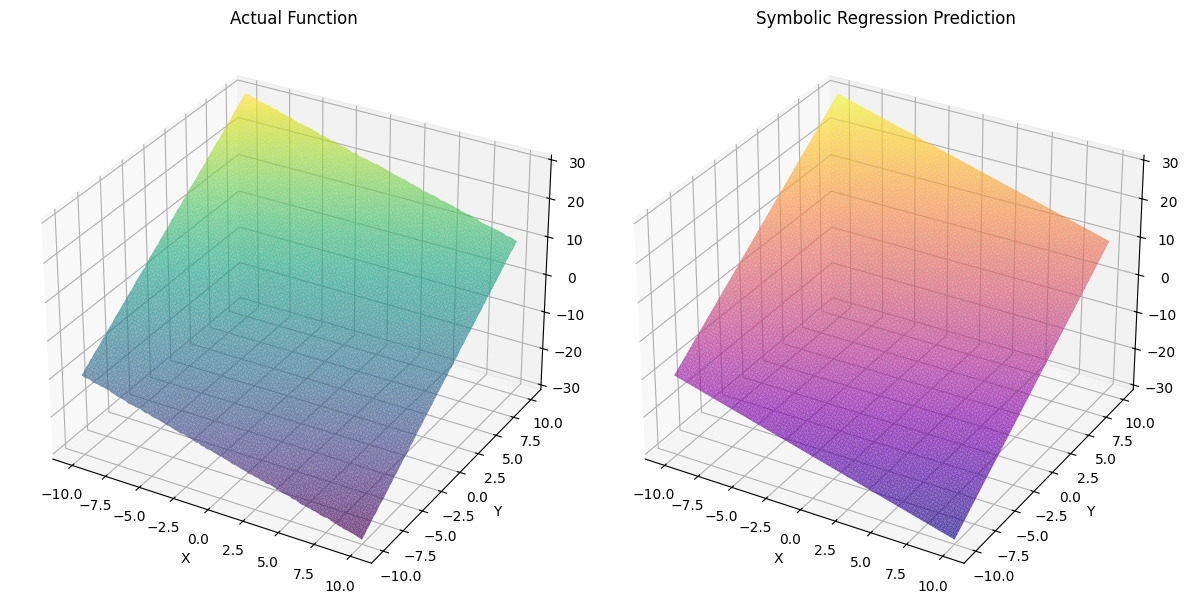

In [545]:
compare_3d_plot(X_f, best_pred, data_f)